# Environment Setup

In [1]:
#.env file is used to store the Groq and Tavily API keys 
#API (Application Programming Interface) keys - this is sent with each API request 
#loading the API keys 

from dotenv import load_dotenv
import os 

load_dotenv('.env') #looks for a .env file in folder 

GROQ_API_KEY = os.getenv('GROQ_API_KEY') #fetches the API keys as a Python string 
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')


In [2]:
#if there is an error 
assert GROQ_API_KEY, "GROQ_API_KEY not set" #displays the message and stops execution when API Key not set 
assert TAVILY_API_KEY, "TAVILY_API_KEY not set"

# Data Loading and Preprocessing

In [3]:
#loading all PDFs from the crew_data folder 
from langchain_community.document_loaders import PyPDFDirectoryLoader
loader = PyPDFDirectoryLoader('crew_data')
documents = loader.load()

print(f"Loaded {len(documents)} documents")

#chunking documents 
from langchain_text_splitters import RecursiveCharacterTextSplitter 
#RecursiveCharacterTextSplitter is a text splitter from LangChain that cuts long text into chunks of a certain size (eg. 1000 characters) 
#splits by paragraphs, line breaks, spaces and individual characters (in that order, moves on to the next if the first split is too big)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, #characters per chunk
    chunk_overlap=200 #overlap between consecutive chunks, info can overlap in different chunks
) 

chunks = text_splitter.split_documents(documents) #applies text_splitter to the documents 


Loaded 80 documents


In [16]:
#!pip install sentence-transformers

  Using cached transformers-5.1.0-py3-none-any.whl.metadata (31 kB)
  Using cached torch-2.10.0-cp310-cp310-win_amd64.whl.metadata (31 kB)
Using cached transformers-5.1.0-py3-none-any.whl (10.3 MB)
Using cached torch-2.10.0-cp310-cp310-win_amd64.whl (113.7 MB)

   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   -------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.2+cpu requires torch==2.1.2, but you have torch 2.10.0 which is incompatible.
torchvision 0.16.2+cpu requires torch==2.1.2, but you have torch 2.10.0 which is incompatible.


   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 

In [18]:
#!pip install -U langchain-huggingface

  Using cached huggingface_hub-0.36.2-py3-none-any.whl.metadata (15 kB)
Using cached huggingface_hub-0.36.2-py3-none-any.whl (566 kB)

  Attempting uninstall: huggingface-hub

    Found existing installation: huggingface_hub 1.4.1

   ---------------------------------------- 0/2 [huggingface-hub]
    Uninstalling huggingface_hub-1.4.1:
   ---------------------------------------- 0/2 [huggingface-hub]
      Successfully uninstalled huggingface_hub-1.4.1
   ---------------------------------------- 0/2 [huggingface-hub]
   ---------------------------------------- 0/2 [huggingface-hub]
   ---------------------------------------- 0/2 [huggingface-hub]
   ---------------------------------------- 0/2 [huggingface-hub]
   ---------------------------------------- 0/2 [huggingface-hub]
   ---------------------------------------- 0/2 [huggingface-hub]
   ---------------------------------------- 0/2 [huggingface-hub]
   ---------------------------------------- 0/2 [huggingface-hub]
   ------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 5.1.0 requires huggingface-hub<2.0,>=1.3.0, but you have huggingface-hub 0.36.2 which is incompatible.


In [57]:
#converting chunks to embedding vectors (numerical) using local/HuggingFace embedding model (to prevent running out of quotas in OpenAI)
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [58]:
#index embeddings with FAISS 
from langchain_community.vectorstores import FAISS 

#build the FAISS vectorstore from chunks 
vectorstore = FAISS.from_documents(chunks, embeddings)

# Retrieval-Augmented QA 
The FAISS vectorstore is used to retrieve documents relevant to a user’s query. The query and context are passed to the LLM to generate a meaningful response.

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    api_key="GROQ_API_KEY",
    model="llama-3.1-8b-instant",
    temperature=0.2,
    max_tokens=None,
)

In [60]:
from langchain_classic.chains import RetrievalQA

retriever = vectorstore.as_retriever()  # FAISS vectorstore

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff"  
)

In [61]:
#testing 
query = "What is the 22q11.2 Deletion Syndrome?"
result = qa_chain.invoke({"query": query})
print(result["result"])

The 22q11.2 Deletion Syndrome (22q11.2DS) is a chromosomal microdeletion syndrome. It is the most frequent chromosomal microdeletion syndrome and one of the strongest cytogenetic risk factors for a broad spectrum of psychiatric disorders.

The syndrome is caused by a deletion of a small segment of chromosome 22, specifically the q11.2 region. This deletion can lead to a range of physical, developmental, and psychiatric problems.

Individuals with 22q11.2DS are at a high risk of developing various psychiatric disorders, including schizophrenia, anxiety disorders, attention deficit hyperactivity disorder (ADHD), and mood disorders. They may also experience learning disabilities, speech and language difficulties, and hearing impairments.

The syndrome is often associated with a range of physical characteristics, including a distinctive facial appearance, heart defects, and palatal abnormalities. It is estimated that nearly 30% of 22q11.2 deletion carriers develop schizophrenia during thei

## Tavily Search Integration
Tavily lets you add real-time web search capability to your AI agents.
Great for retrieving up-to-date web data — ideal for dynamic and current-event-based use cases.

In [62]:
!pip install tavily-python

In [63]:
from tavily import TavilyClient

tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

In [64]:
tavily_client.search(query="latest advancements in LLMs")

{'query': 'latest advancements in LLMs',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.linkedin.com/pulse/recent-advancements-large-language-models-llms-tim-harper-pmp-nb1wc',
   'title': 'Recent advancements in large language models (LLMs) and their ...',
   'content': 'LLMs are now deeply integrated into workflows across software development, creative industries, data analysis, customer service, research, and automation.',
   'score': 0.7644879,
   'raw_content': None},
  {'url': 'https://www.geeksforgeeks.org/machine-learning/future-of-large-language-models/',
   'title': 'Future of Large Language Models - GeeksforGeeks',
   'content': "In addition, LLMs may provide more advancements to simplify users' daily live tasks, innovate the concept of responsive computing, and more.",
   'score': 0.6760432,
   'raw_content': None},
  {'url': 'https://prajnaaiwisdom.medium.com/llm-trends-2025-a-deep-dive-into-the-future-of-large-language-mode

In [65]:
!pip install -qU crewai "crewai[tools]" tavily-python

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.113 requires chromadb<0.5.0,>=0.4.24, but you have chromadb 1.1.1 which is incompatible.
embedchain 0.1.113 requires langchain<0.2.0,>=0.1.4, but you have langchain 1.2.9 which is incompatible.
embedchain 0.1.113 requires langchain-openai<0.2.0,>=0.1.7, but you have langchain-openai 1.1.7 which is incompatible.
embedchain 0.1.113 requires tiktoken<0.8.0,>=0.7.0, but you have tiktoken 0.8.0 which is incompatible.
grpcio-status 1.78.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.6 which is incompatible.
langchain-cohere 0.1.5 requires langchain-core<0.3,>=0.1.42, but you have langchain-core 1.2.9 which is incompatible.
langchain-openai 1.1.

## CrewAI Agent Creation 

In [66]:
#setting up Tavily and RAG 
from crewai_tools import TavilySearchTool
from crewai.tools import tool

#Tavily web search tool 
tavily_tool = TavilySearchTool() 

#wrapper tool for existing qa_chain for vectorstore RAG 
@tool('rag_pdf_search')
def rag_pdf_search(query: str) -> str:
    """Answer questions using the local PDF knowledge base."""
    result = qa_chain.invoke({'query': query})
    #RetrievalQA returns a dictionary with "result" by default 
    return result['result'] if isinstance(result, dict) else str(result)

#gives a FAISS/RAG tool for custom PDFs and a Tavily search tool for live web data

In [67]:
#example 
answer = rag_pdf_search.run("What is the 22q11.2 Deletion Syndrome?")
print(answer)

The 22q11.2 Deletion Syndrome (22q11.2DS) is a chromosomal microdeletion syndrome. It is the most frequent chromosomal microdeletion syndrome and one of the strongest cytogenetic risk factors for a broad spectrum of psychiatric disorders.

In simpler terms, 22q11.2DS is a genetic disorder caused by a small missing piece of chromosome 22, specifically the q11.2 region. This deletion can lead to a variety of physical, developmental, and psychiatric problems.

Individuals with 22q11.2DS may experience a range of symptoms, including:

* Physical characteristics such as a cleft palate, heart defects, and distinctive facial features
* Developmental delays and learning disabilities
* Increased risk of psychiatric disorders, such as schizophrenia, anxiety, and attention deficit hyperactivity disorder (ADHD)
* Hearing impairment, which can be a significant issue for many individuals with 22q11.2DS

The exact cause of 22q11.2DS is not fully understood, but it is thought to be related to the dele

## defining the three agents 

In [68]:
from crewai import Agent

# 1. Researcher Agent
researcher = Agent(
    role="Researcher",
    goal=(
        "Conduct deep research on a given query using both the local PDF "
        "knowledge base and real-time web search."
    ),
    backstory=(
        "You are an expert research analyst. You know how to read vectorstore "
        "results from the PDF knowledge base and combine them with fresh web "
        "information to produce a thorough evidence summary."
    ),
    tools=[rag_pdf_search, tavily_tool],
    llm=llm,
    verbose=True,
)

In [69]:
# 2. Writer Agent
writer = Agent(
    role="Content Writer",
    goal=(
        "Generate clear, structured, well-organised answers or reports based "
        "on the Researcher’s findings."
    ),
    backstory=(
        "You are a skilled technical writer. You take research notes and turn "
        "them into polished, easy-to-read explanations and reports."
    ),
    tools=[],  # relies on LLM + context from tasks
    llm=llm,
    verbose=True,
)

In [70]:
# 3. Critic Agent
critic = Agent(
    role="Reviewer",
    goal=(
        "Review the Writer’s answer for factual accuracy, coherence, and "
        "completeness, and suggest improvements."
    ),
    backstory=(
        "You are a meticulous reviewer who checks arguments, corrects errors, "
        "and improves clarity and structure."
    ),
    tools=[],  # uses just the LLM to critique text
    llm=llm,
    verbose=True,
)


## Task 1: Explore the Vectorstore  
Use .similarity_search() to see what documents match a query.
Visualize embeddings using PCA or t-SNE.

In [71]:
query = "What is the 22q11.2 Deletion Syndrome?"
results = vectorstore.similarity_search(query, k=3) #top 3 chunks
#query is embedded using the same embedding model as the documents and vector similarity is computed (cosine similarity)
for i, doc in enumerate(results, 1):
    print(f"\n--- Result {i} ---")
    print("Source:", doc.metadata) 
    #doc.metadata contains source file name, page number, chunk index, section title
    print(doc.page_content[:400], '...') #400 characters chunked 


--- Result 1 ---
Source: {'producer': 'iText® 5.3.5 ©2000-2012 1T3XT BVBA (SPRINGER SBM; licensed version)', 'creator': 'Springer', 'creationdate': '2025-01-08T22:00:26+05:30', 'keywords': '', 'crossmarkdomains[1]': 'springer.com', 'moddate': '2025-01-08T18:57:44+01:00', 'subject': 'Translational Psychiatry, doi:10.1038/s41398-024-03218-x', 'doi': '10.1038/s41398-024-03218-x', 'author': 'Chen Lu', 'crossmarkdomains[2]': 'springerlink.com', 'title': 'Auditory evoked-potential abnormalities in a mouse model of 22q11.2 Deletion Syndrome and their interactions with hearing impairment', 'source': 'crew_data\\s41398-024-03218-x.pdf', 'total_pages': 13, 'page': 10, 'page_label': '11'}
CODE AVAILABILITY
Analysis code is available from the corresponding author on request.
REFERENCES
1. McDonald-McGinn DM, Sullivan KE, Marino B, Philip N, Swillen A, Vorstman JAS,
et al. 22q11.2 deletion syndrome. Nat Rev Dis Primers. 2015;1:15071.
2. Singh T, Poterba T, Curtis D, Akil H, Al Eissa M, Barchas JD,

In [74]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 6.3 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 6.1 MB/s eta 0:00:01
   ----------- ---------------------------- 2.4/8.1 MB 6.1 MB/s eta 0:00:01
   ------------ --------------------------- 2.6/8.1 MB 4.2 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 3.5 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.1 MB 3.1 MB/s eta 0:00:02
   --------------------- ------------------ 4.5/8.1 MB 3.2 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 3.2 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 2.8 MB/s eta 0:00:02
   ------------------------- -------------- 5.2/8.1 MB 2.8 MB/s eta 0:00:02
   ------------------------- -------------- 5.2/8.1 MB 2.8 MB/s eta 0:00:02
   ----------------------------

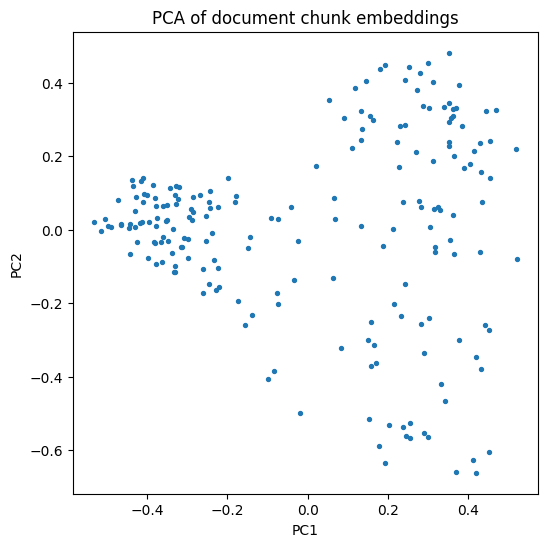

In [75]:
#visualising embeddings with PCA (Principal Component Analysis)
from sklearn.decomposition import PCA 
import numpy as np
import matplotlib.pyplot as plt 

#taking first 200 chunks for visualisation 
sample_chunks=chunks[:200]
texts = [c.page_content for c in sample_chunks]

#get embedding vectors 
vectors = np.array(embeddings.embed_documents(texts)) 

#reduce to 2D with PCA 
pca = PCA(n_components=2)
vecs_2d = pca.fit_transform(vectors) 

plt.figure(figsize=(6,6))
plt.scatter(vecs_2d[:,0], vecs_2d[:, 1], s=8)
plt.title('PCA of document chunk embeddings')
plt.xlabel('PC1') #maximum variance (higher variance capture meaningful differences)
plt.ylabel('PC2') #the next most informative direction
plt.show()

### interpretation 
- chunks that lie close together have similar embeddings - semantically similar chunks in document
- very visible dense group on left side = one theme cluster
- overall similar themes in the documents 

## Task 2: Expand the Knowledge Base
Add new documents to crew_data.
Rebuild the FAISS index and test retrieval with new queries.

In [76]:
# 1. Reload documents
loader = PyPDFDirectoryLoader("crew_data")
documents = loader.load()

# 2. Re-chunk
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
chunks = text_splitter.split_documents(documents)

# 3. Rebuild vectorstore
vectorstore = FAISS.from_documents(chunks, embeddings)

In [77]:
results = vectorstore.similarity_search(
    "What new information is in the recently added documents?", k=4
)
for i, doc in enumerate(results, 1):
    print(f"\n--- Result {i} ---")
    print("Source:", doc.metadata)
    print(doc.page_content[:400], "...")


--- Result 1 ---
Source: {'producer': 'pdf-lib (https://github.com/Hopding/pdf-lib)', 'creator': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36 + Paged.js', 'creationdate': '2024-07-19T13:25:37+00:00', 'moddate': '2024-07-19T13:25:37+00:00', 'title': '98415', 'source': 'crew_data\\98415-v1.pdf', 'total_pages': 35, 'page': 9, 'page_label': '10'}
days. Each color ed line r epr esents a unit; the solid black line is the median acr oss units. Insets sho w zoomed-in vie ws of the
bulk of the data, between days 0 and 5. Normalized field alignment r emained close to 1.0 acr oss sessions for most PRFs and
C GFs, indicating that neur on-specific PRF and C GF structur e was pr eserved for many days in most neur ons. ...

--- Result 2 ---
Source: {'producer': 'pdfTeX-1.40.20', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-02-21T15:10:28+00:00', 'author': '', 'keywords': '', 'moddate': '2026-01-25T05:56:19-08:00', 'ptex.fullbanner'

## Create a new AI agent 
Define a new role (e.g., “Trend Analyst”).
Give it the Tavily tool and a goal like “Summarize the latest news on AI”.

In [82]:
from crewai import Task, Crew

trend_analyst = Agent(
    role='Trend Analyst',
    goal='Summarize the latest news and trends in AI in a clear, concise way,',
    backstory=(
        'You are an AI trends researcher who monitors recent developments in '
        'AI models, tools, and applications, focusing on reliable sources.'
    ),
    tools=[tavily_tool],
    llm=llm,
    verbose=True,
)

trend_task = Task(
    description=(
        'Research the latest news and trends in artificial intelligence from '
        'the last few months. Focus on major model releases, notable research '
        'papers, and real-world applications.'
    ),
    expected_output=(
        'A bullet-point summary of the top 5-7 current AI trends, with 1-2 '
        'sentences explaining each trend.'
    ),
    agent=trend_analyst,
)

In [79]:
#to run this task
trend_crew = Crew(agents=[trend_analyst], tasks=[trend_task], verbose=True)
trend_summary = trend_crew.kickoff()
print(trend_summary)

╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  364e68a6-07f2-4131-b2e7-5ff76f1b9d41                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: Research the latest news and trends in artificial intelligence from the last few months. Focus on major  │
│  model releases, notable research papers, and real-world applications.                                          │
│  ID: 6b41b3a9-7538-4092-8c20-da43cd323ea3                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Trend Analyst                                                                                           │
│                                                                                                                 │
│  Task: Research the latest news and trends in artificial intelligence from the last few months. Focus on major  │
│  model releases, notable research papers, and real-world applications.                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

ERROR:root:Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}
ERROR:root:OpenAI API call failed: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


╭───────────────────────────────────────────────── ❌ LLM Error ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  LLM Call Failed                                                                                                │
│  Error: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model                │
│  `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error',      │
│  'param': None, 'code': 'model_not_found'}}                                                                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[CrewAIEventsBus] Warning: Event pairing mismatch. 'llm_call_failed' closed 'agent_execution_started' (expected 
'llm_call_started')

An unknown error occurred. Please check the details below.
Error details: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}
An unknown error occurred. Please check the details below.
Error details: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


╭───────────────────────────────────────────────── ❌ LLM Error ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  LLM Call Failed                                                                                                │
│  Error: OpenAI API call failed: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message':   │
│  'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type':                    │
│  'invalid_request_error', 'param': None, 'code': 'model_not_found'}}                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Trend Analyst                                                                                           │
│                                                                                                                 │
│  Task: Research the latest news and trends in artificial intelligence from the last few months. Focus on major  │
│  model releases, notable research papers, and real-world applications.                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

ERROR:root:Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}
ERROR:root:OpenAI API call failed: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


╭───────────────────────────────────────────────── ❌ LLM Error ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  LLM Call Failed                                                                                                │
│  Error: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model                │
│  `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error',      │
│  'param': None, 'code': 'model_not_found'}}                                                                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[CrewAIEventsBus] Warning: Event pairing mismatch. 'llm_call_failed' closed 'agent_execution_started' (expected 
'llm_call_started')

An unknown error occurred. Please check the details below.
Error details: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}
An unknown error occurred. Please check the details below.
Error details: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


╭───────────────────────────────────────────────── ❌ LLM Error ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  LLM Call Failed                                                                                                │
│  Error: OpenAI API call failed: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message':   │
│  'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type':                    │
│  'invalid_request_error', 'param': None, 'code': 'model_not_found'}}                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Trend Analyst                                                                                           │
│                                                                                                                 │
│  Task: Research the latest news and trends in artificial intelligence from the last few months. Focus on major  │
│  model releases, notable research papers, and real-world applications.                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

ERROR:root:Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}
ERROR:root:OpenAI API call failed: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


╭───────────────────────────────────────────────── ❌ LLM Error ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  LLM Call Failed                                                                                                │
│  Error: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model                │
│  `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error',      │
│  'param': None, 'code': 'model_not_found'}}                                                                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[CrewAIEventsBus] Warning: Event pairing mismatch. 'llm_call_failed' closed 'agent_execution_started' (expected 
'llm_call_started')

An unknown error occurred. Please check the details below.
Error details: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}
An unknown error occurred. Please check the details below.
Error details: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


[CrewAIEventsBus] Warning: Event pairing mismatch. 'agent_execution_error' closed 'task_started' (expected 
'agent_execution_started')

╭───────────────────────────────────────────────── ❌ LLM Error ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  LLM Call Failed                                                                                                │
│  Error: OpenAI API call failed: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message':   │
│  'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type':                    │
│  'invalid_request_error', 'param': None, 'code': 'model_not_found'}}                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[CrewAIEventsBus] Warning: Event pairing mismatch. 'task_failed' closed 'crew_kickoff_started' (expected 
'task_started')

╭──────────────────────────────────────────────── 📋 Task Failure ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Failed                                                                                                    │
│  Name:                                                                                                          │
│  Research the latest news and trends in artificial intelligence from the last few months. Focus on major model  │
│  releases, notable research papers, and real-world applications.                                                │
│  Agent:                                                                                                         │
│  Trend Analyst                                                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[CrewAIEventsBus] Warning: Ending event 'crew_kickoff_failed' emitted with empty scope stack. Missing starting 
event?

╭───────────────────────────────────────────────── Crew Failure ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Failed                                                                                          │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  364e68a6-07f2-4131-b2e7-5ff76f1b9d41                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

ValueError: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

## Report Generator Agent 
Design an agent to collect insights and export them as a structured report (Markdown, PDF, etc.).

In [80]:
report_generator = Agent(
    role="Report Generator",
    goal=(
        "Compile insights from multiple agents and generate a clear, "
        "well-structured research report in Markdown format."
    ),
    backstory=(
        "You are a professional report writer and editor. You specialize "
        "in organizing complex research into clean, readable documents "
        "suitable for technical and non-technical audiences."
    ),
    tools=[],  # no tools needed
    llm=llm,
    verbose=True,
)

report_task = Task(
    description=(
        "Using the outputs from previous agents, generate a structured "
        "research report in Markdown format. The report should include an "
        "executive summary, key findings, recent trends, and conclusions."
    ),
    expected_output=(
        "A well-formatted Markdown report with clear section headings, "
        "bullet points where appropriate, and professional tone."
    ),
    agent=report_generator,
)


In [85]:
#exporting the report as markdown 
crew = Crew(
    agents=[researcher],
    tasks=[report_task],
)
final_report = crew.kickoff()

with open("ai_research_report.md", "w", encoding="utf-8") as f:
    f.write(final_report)

print("Report saved as ai_research_report.md")

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Report Generator                                                                                        │
│                                                                                                                 │
│  Task: Using the outputs from previous agents, generate a structured research report in Markdown format. The    │
│  report should include an executive summary, key findings, recent trends, and conclusions.                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

ERROR:root:Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}
ERROR:root:OpenAI API call failed: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


[CrewAIEventsBus] Warning: Event pairing mismatch. 'llm_call_failed' closed 'agent_execution_started' (expected 
'llm_call_started')

An unknown error occurred. Please check the details below.
Error details: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}
An unknown error occurred. Please check the details below.
Error details: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}


[CrewAIEventsBus] Warning: Event pairing mismatch. 'agent_execution_error' closed 'task_started' (expected 
'agent_execution_started')

[CrewAIEventsBus] Warning: Event pairing mismatch. 'task_failed' closed 'crew_kickoff_started' (expected 
'task_started')

[CrewAIEventsBus] Warning: Ending event 'crew_kickoff_failed' emitted with empty scope stack. Missing starting 
event?

ValueError: Model llama-3.1-8b-instant not found: Error code: 404 - {'error': {'message': 'The model `llama-3.1-8b-instant` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}